# Inferring Synaptic Weights from Network Activity

Here we compare plausible methods for overcoming the ''weight transport'' problem.

<img src="https://raw.githubusercontent.com/nasiryahm/STDWI/master/WeightTransportIllustration.png" width="80%">

The illustration above depicts this issue. See the middle pane for the mathematical origin of the requirement of feedforward weight matrices for the error backpropagation.

There are two key and recent methods which propose that the feedback error connectivity could be __learned__ by an inference process based upon the activity of the pre and post-synaptic neurons. These are regression discontinuity design (RDD) [1], and a rate-based method which we refer to as the Akrout method [2].

We compare these methods against a simple and powerful method inspired by the analytic solution to a leaky-integrate and fire neuron.
We refer to this method as Spike Timing-Dependent Weight Inference.

[1] Guerguiev J, Kording KP, Richards BA. Spike-based causal inference for weight alignment. arXiv [q-bio.NC]. 2019. Available: http://arxiv.org/abs/1910.01689 

[2] Akrout, M., Wilson, C., Humphreys, P. C., Lillicrap, T., & Tweed, D. (2019). Deep Learning without Weight Transport. In arXiv [cs.LG]. arXiv. http://arxiv.org/abs/1904.05391

In [1]:
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

from weight_inference import simulator
from weight_inference import methods
from weight_inference import fitter

In [2]:
# Function to plot spike train without borders:
def plot_spike_train(spike_trains, simulation_time, color='k', alpha='1.0', size=2500):
    nb_units = len(spike_trains)
    for i in range(nb_units):
        spikes = spike_trains[i][spike_trains[i] < simulation_time]
        plt.scatter(spikes, i*np.ones((len(spikes))),
                    marker="|", s=(size/nb_units), color=color, alpha=alpha)
    
    # Getting rid of bounding box
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax

Setting up the network shape, synaptic weights, and input stimulation

In [3]:
# Network Shape
nb_input_neurons, nb_output_neurons = 100, 10

# Simulation details
simulation_time = 2e5 #ms
# timestep = 0.25 #ms
timestep = 25 #ms
nb_timesteps = simulation_time // timestep

# Stimulation Generation
ratio_stimulated = 0.2
stimulation_spike_trains = simulator.poisson_spike_train(
        nb_input_neurons, 200/1000, simulation_time, timestep) # 200Hz stimulation
stimulation_spike_trains = simulator.random_sample_spike_train(
    stimulation_spike_trains, simulation_time, timestep, 100, ratio_stimulated) # resampling every 100ms with probability 0.1

# Stimulation->Input weights
# Creating weight matrices from stimulation to input and input to output
stim_scale = 10.0
stim_input_weights = stim_scale*np.eye(nb_input_neurons, nb_input_neurons) # One to one with a particular scale

# Input->Output neuron synaptic weight matrix
input_scale = 7.5*stim_scale # Compensating for hidden layer mean weight, firing rates and number)
r = np.random.RandomState(seed=42)
input_output_weights = input_scale*((np.sqrt(0.2)/np.sqrt(nb_input_neurons*ratio_stimulated))*r.normal(size=(nb_output_neurons, nb_input_neurons)) + (1 / (nb_input_neurons*ratio_stimulated)))


### Simulating the network activity

In [4]:
# Computing stimulation to input neurons
stimulation_xpsps = simulator.spike_trains_to_xpsps(stimulation_spike_trains, simulation_time, timestep)

# Computing input neuron activity
input_neuron_acc, input_neuron_mem, input_neuron_spike_trains = simulator.lif_dynamics(
        stimulation_xpsps, stim_input_weights, timestep)
input_neuron_xpsps = simulator.spike_trains_to_xpsps(input_neuron_spike_trains, simulation_time, timestep)

# Computing output neuron activity
output_neuron_acc, output_neuron_mem, output_neuron_spike_trains = simulator.lif_dynamics(
        input_neuron_xpsps, input_output_weights, timestep)
output_neuron_xpsps = simulator.spike_trains_to_xpsps(output_neuron_spike_trains, simulation_time, timestep)

C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:234: RuntimeWarning: overflow encountered in add
  dacc = ((rest + drift) - acc_voltage[:, t_indx - 1]) + coupling_ratio*(total_input - acc_voltage[:, t_indx - 1])
C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:235: RuntimeWarning: overflow encountered in multiply
  acc_voltage[:, t_indx] = acc_voltage[:, t_indx - 1] + (timestep / tau) * dacc
C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:235: RuntimeWarning: invalid value encountered in add
  acc_voltage[:, t_indx] = acc_voltage[:, t_indx - 1] + (timestep / tau) * dacc


### Visualising network activity

Text(0, 0.5, 'Output Neuron ID')

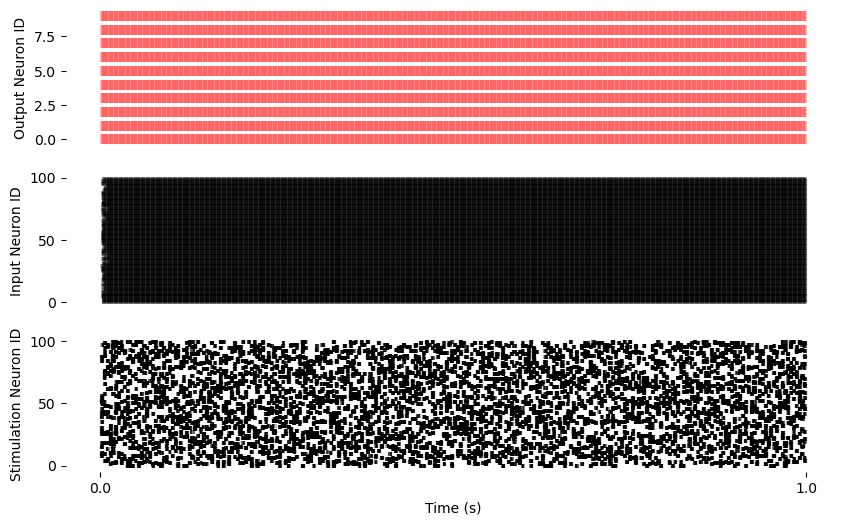

In [5]:
plt.figure(figsize=(10,6), dpi=100)

plt.subplot(3,1,3)
ax = plot_spike_train(stimulation_spike_trains, 1e3, alpha=0.25, size=500)
plt.xticks([0.0, 1e3], [0.0, 1.0])
plt.xlabel("Time (s)")
plt.ylabel("Stimulation Neuron ID")

plt.subplot(3,1,2)
ax = plot_spike_train(input_neuron_spike_trains, 1e3, alpha=0.25, size=500) #alpha=0.25, added here
plt.xticks([])
plt.ylabel("Input Neuron ID")

plt.subplot(3,1,1)
ax = plot_spike_train(output_neuron_spike_trains, 1e3,alpha=0.25, size=500, color='red') #alpha=0.25, added here
plt.xticks([])
plt.ylabel("Output Neuron ID")

### Inferring synaptic weights from activity

In [6]:
# Starting with a zero-centred small variance guess
initial_guess_matrix = 0.001*(r.uniform(size=(nb_output_neurons, nb_input_neurons)) - 0.5)
learning_rate = 5e-4
check_interval = 10

In [7]:
batch_size = 10
akrout_guesses = fitter.akrout(
            initial_guess_matrix,
            input_neuron_spike_trains,
            output_neuron_spike_trains,
            simulation_time,
            100,  # resample period
            10,   # batch size
            learning_rate,
            check_interval)
''' # commented out the section as it was causing an error, may be imp to look at
tau_fast, tau_slow = 10.0, 200.0
stdwi_guesses = fitter.stdwi(
                initial_guess_matrix,
                input_neuron_spike_trains,
                output_neuron_spike_trains,
                simulation_time,
                100,
                timestep,
                tau_fast/tau_slow, tau_slow,
                1.0, tau_fast,
                learning_rate, check_interval)
'''
alpha = 0.05
window_size = 40
rdd_guesses = fitter.rdd(
                initial_guess_matrix,
                input_neuron_mem,
                input_neuron_acc,
                output_neuron_xpsps,
                alpha, window_size,
                1.0, # Spiking threshold
                timestep,
                learning_rate,
                check_interval)

Text(0.5, 1.0, 'RDD Method')

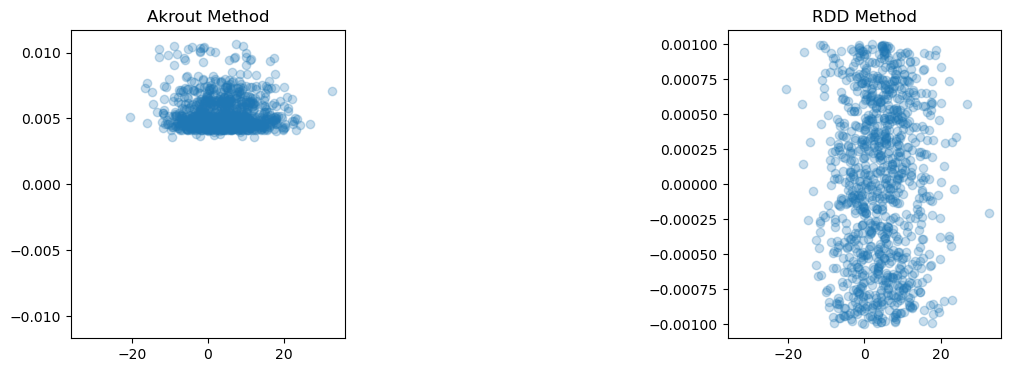

In [8]:
plt.figure(figsize=(12,4))
xmax = np.max(np.abs(input_output_weights.flatten()))*1.1

plt.subplot(1,3,1)
plt.scatter(input_output_weights.flatten(), akrout_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])
plt.ylim([-1.1*np.max(np.abs(akrout_guesses[-1].flatten())), 1.1*np.max(np.abs(akrout_guesses[-1].flatten()))])
plt.title("Akrout Method")
''' # as before we are removing section dependent on stdwi_guesses
plt.subplot(1,3,2)
plt.scatter(input_output_weights.flatten(), stdwi_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])
plt.ylim([-1.1*np.max(np.abs(stdwi_guesses[-1].flatten())), 1.1*np.max(np.abs(stdwi_guesses[-1].flatten()))])
plt.title("STDWI Method")
'''
plt.subplot(1,3,3)
plt.scatter(input_output_weights.flatten(), rdd_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])
plt.ylim([-1.1*np.max(np.abs(rdd_guesses[-1].flatten())), 1.1*np.max(np.abs(rdd_guesses[-1].flatten()))])
plt.title("RDD Method")

### Measuring accuracies

In [9]:
pearson_correlations = [[], [], []]
sign_accuracies = [[], [], []]

results = [akrout_guesses, rdd_guesses]
# older code that had stdwi guesses
#results = [akrout_guesses, stdwi_guesses, rdd_guesses]

for r_indx in range(len(results)):
    for r_guess in results[r_indx]:
        pearson_correlations[r_indx].append(spstats.pearsonr(r_guess.flatten(), input_output_weights.flatten())[0])
        sign_accuracies[r_indx].append(methods.sign_alignment(r_guess.flatten(), input_output_weights.flatten()))

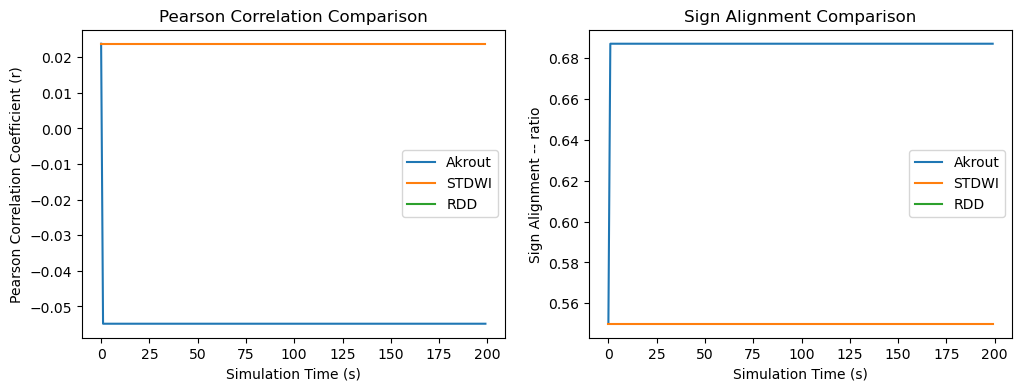

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Pearson Correlation Comparison')
plt.plot(pearson_correlations[0], label='Akrout')
plt.plot(pearson_correlations[1], label='STDWI')
plt.plot(pearson_correlations[2], label='RDD')
plt.xlabel("Simulation Time (s)")
plt.ylabel("Pearson Correlation Coefficient (r)")

plt.legend()
plt.subplot(1,2,2)
plt.title('Sign Alignment Comparison')
plt.plot(sign_accuracies[0], label='Akrout')
plt.plot(sign_accuracies[1], label='STDWI')
plt.plot(sign_accuracies[2], label='RDD')
plt.xlabel("Simulation Time (s)")
plt.ylabel("Sign Alignment -- ratio")
plt.legend()

In [11]:
def add_noise_to_spike_trains(spike_trains, noise_level=0.05, simulation_time=None, timestep=None):
    """
    Add random noise to spike trains by randomly adding or removing spikes.
    
    Parameters:
    - spike_trains: list of spike times for each neuron
    - noise_level: probability of adding/removing a spike
    - simulation_time: total simulation time (for adding new spikes)
    - timestep: simulation timestep (for adding new spikes)
    
    Returns:
    - noisy_spike_trains: spike trains with added noise
    """
    noisy_spike_trains = []
    for spikes in spike_trains:
        # Remove some spikes randomly
        mask = np.random.random(len(spikes)) > noise_level
        noisy_spikes = spikes[mask]
        
        # Add some random spikes
        if simulation_time is not None and timestep is not None:
            n_new_spikes = int(noise_level * len(spikes))
            new_spikes = np.random.uniform(0, simulation_time, n_new_spikes)
            noisy_spikes = np.sort(np.concatenate([noisy_spikes, new_spikes]))
        
        noisy_spike_trains.append(noisy_spikes)
    
    return noisy_spike_trains

In [12]:
# Add noise to the spike trains
noisy_input_spike_trains = add_noise_to_spike_trains(input_neuron_spike_trains, 
                                                    noise_level=0.1,
                                                    simulation_time=simulation_time,
                                                    timestep=timestep)

noisy_output_spike_trains = add_noise_to_spike_trains(output_neuron_spike_trains,
                                                     noise_level=0.1,
                                                     simulation_time=simulation_time,
                                                     timestep=timestep)

In [17]:
def enhanced_akrout(initial_weights, input_spikes, output_spikes, 
                   simulation_time, batch_size, learning_rate, 
                   check_interval, max_weight=10.0, momentum=0.9):
    """
    Enhanced Akrout method with noise, weight constraints, and momentum.
    
    Parameters:
    - initial_weights: initial weight matrix
    - input_spikes: input neuron spike trains
    - output_spikes: output neuron spike trains
    - simulation_time: total simulation time
    - batch_size: number of samples per batch
    - learning_rate: initial learning rate
    - check_interval: how often to check progress
    - max_weight: maximum allowed weight value
    - momentum: momentum parameter for smoother updates
    
    Returns:
    - weight_history: list of weight matrices over time
    """
    # Initialize
    weights = initial_weights.copy()
    weight_history = [weights.copy()]
    velocity = np.zeros_like(weights)  # For momentum
    
    # Convert spike trains to continuous signals
    input_xpsps = simulator.spike_trains_to_xpsps(input_spikes, simulation_time, timestep)
    output_xpsps = simulator.spike_trains_to_xpsps(output_spikes, simulation_time, timestep)
    
    # Calculate number of batches
    n_batches = int(simulation_time // (batch_size * timestep))
    
    for batch in range(n_batches):
        # Calculate time window for this batch
        start_time = batch * batch_size * timestep
        end_time = (batch + 1) * batch_size * timestep
        
        # Get spikes in this batch - slice along TIME axis (axis=1)
        start_idx = int(start_time/timestep)
        end_idx = int(end_time/timestep)
        
        batch_input = input_xpsps[:, start_idx:end_idx]   # Shape: (n_input_neurons, batch_size)
        batch_output = output_xpsps[:, start_idx:end_idx] # Shape: (n_output_neurons, batch_size)
        
        # Calculate weight update (Akrout rule)
        # Mean over time (axis=1), then outer product
        input_mean = batch_input.mean(axis=1)   # Shape: (n_input_neurons,)
        output_mean = batch_output.mean(axis=1) # Shape: (n_output_neurons,)
        
        # Outer product: output x input -> (n_output, n_input)
        delta_weights = np.outer(output_mean, input_mean)
        
        # Add momentum
        velocity = momentum * velocity + (1 - momentum) * delta_weights
        
        # Update weights with adaptive learning rate
        current_lr = learning_rate * (1 - batch/n_batches)  # Linear decay
        weights += current_lr * velocity
        
        # Apply weight constraints
        weights = np.clip(weights, 0, max_weight)  # Keep weights positive and bounded
        
        # Record weights at check intervals
        if batch % check_interval == 0:
            weight_history.append(weights.copy())
    
    return weight_history

In [18]:
# Parameters
batch_size = 10
learning_rate = 5e-4
check_interval = 10
max_weight = 10.0
momentum = 0.9

# Run enhanced Akrout method
enhanced_akrout_guesses = enhanced_akrout(
    initial_guess_matrix,
    noisy_input_spike_trains,  # Using noisy inputs
    noisy_output_spike_trains, # Using noisy outputs
    simulation_time,
    batch_size,
    learning_rate,
    check_interval,
    max_weight,
    momentum
)

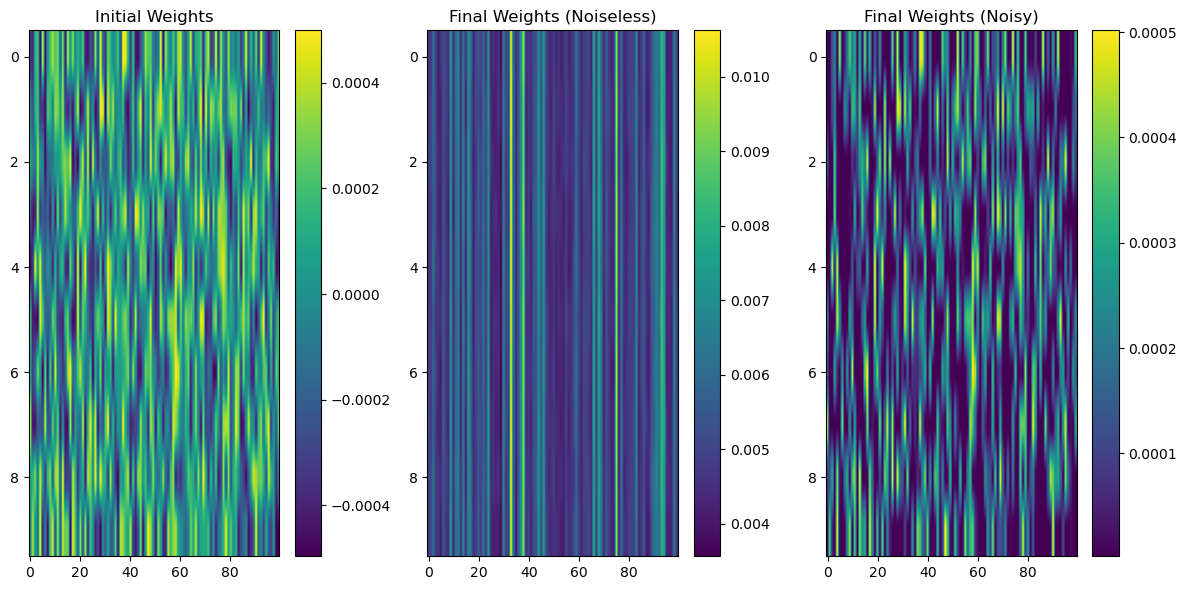

In [19]:
# Plot the evolution of weights
plt.figure(figsize=(12, 6))

# Plot initial weights
plt.subplot(1, 3, 1)
plt.imshow(initial_guess_matrix, cmap='viridis', aspect='auto')
plt.title("Initial Weights")
plt.colorbar()

# Plot final weights (noiseless)
plt.subplot(1, 3, 2)
plt.imshow(akrout_guesses[-1], cmap='viridis', aspect='auto')
plt.title("Final Weights (Noiseless)")
plt.colorbar()

# Plot final weights (noisy)
plt.subplot(1, 3, 3)
plt.imshow(enhanced_akrout_guesses[-1], cmap='viridis', aspect='auto')
plt.title("Final Weights (Noisy)")
plt.colorbar()

plt.tight_layout()
plt.show()